# Movie Industry Analysis

Authors: Cayke Felipe dos Anjos, Dolgor Purbueva

<img src="images/screen.png" alt="Alt text" width="1200"/>

## Overview  
This project analyzes past movies data to offer strategic business recommendations for a new film studio. We aim to predict the most profitable strategies for film production and release by examining production budgets, gross revenues, net profits, genres, popularity, key staff and release timelines. As result this project provides three business recommendations: what genre should a future movie be, what budget to allocate and when to release it.

## Business Problem

The company is expanding its portfolio by investing in a new film studio. Launching a film studio in today's competitive entertainment industry requires a solid understanding of what drives movie success and attracts audiences. The movie industry is known for its substantial risks and high capital demands. Recent developments in AI have made video content creation faster and more efficient, increasing competition but also opening up new opportunities to enter the market.

Our project aims to analyze various datasets, including past movies' financial results, genre correlations, and movie ratings and popularity. By using data analysis techniques, we seek to gain valuable insights and identify patterns that can help shape the company's film production strategy. The goal is to provide three concrete business recommendations that maximize profitability and lower business risks, ensuring a strong entry into the market.

Questions we tried to answer with analysis:
* How should the movie be budgeted?
* What genres are most profitable?
* When should a movie be released?

## Data Understanding

We used datasets from Rotten Tomatoes, TheMovieDB, Bom Office Mojo, IMDB and The Numbers. Each dataset is of different size and contains different data catecories which might be seen as a limitation. For every question we answer we choose the most relevant dataset or merge some of them together for a fuller picture.

For budget related analysis we used IMDB and The Numbers. TheMovieDD dataset was used to explore movie ratings and popularity.

* One of the main metrics we explored is genre. [IMDB defines](https://help.imdb.com/article/contribution/titles/genres/GZDRMS6R742JRGAG?ref_=helpms_h#) genre as a category of artistic composition, characterized by similarities in form, style, or subject matter for a piece of content. [Reaserch by Mustafa Mahmoud Yousry](https://offscreen.com/view/going_to_the_movies) has shown that genre is the main decision factor for audience when chosing a movie to watch.

<img src="images/genre.png" alt="Alt text" width="400"/>

* We introduced the Return on Investment (ROI) metric as a standardized criterion to measure the financial success of a movie relative to its investments, as well as calculated movie net profit.

* We calculated Net Profit.

<img src="images/movie_data_erd.jpeg" alt="Alt text" width="1200"/>

## Data Analysis

In [1]:
import pandas as pd
import numpy as np
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
from math import ceil, floor
import seaborn as sns
import tempfile,zipfile
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

## A risk analysis of the movie production business

In order to provide any business recommendation, we need to understand how much money it is being bet and how much profit is desired in entering this industry. 


Our concept of risk group is then defined: a high risk group is one with a large budget that, if successful, will yield large profit, but if failed, can result in a great loss.

We start by cleaning The Numbers dataset and trying to explain correlations between profit, loss and budget.

In [2]:
#function for cleaning columns and coverting to integer

def clean_and_convert_to_int(column):
    return column.replace({'\$': '', ',': ''}, regex=True).astype(int)

#function for converting to date type

def convert_to_date(column):
    return pd.to_datetime(column, errors='coerce')

#function to clean object columns

def clean_object(column):
    return column.strip().lower()

def split(column):
    return column.str.split(',')

In [3]:
#Cleaning The Numbers DF
tn = pd.read_csv('zippedData/tn.movie_budgets.csv')

#Converting strings to int values. Ex: '$1922819' -> 1922819
tn[['production_budget', 'domestic_gross', 'worldwide_gross']] = tn[['production_budget', 'domestic_gross', 'worldwide_gross']].apply(clean_and_convert_to_int)

#Getting release date in timestamp format to get the year
tn[['release_date']] = tn[['release_date']].apply(convert_to_date)
tn['release_year'] = tn['release_date'].dt.year

#id is an internal identifier
tn = tn.drop(columns=['id'])

#Calculating Net Profit. We only regards international success. A lot of movies have huge budgets and only become profitable internationally
tn['worldwide_net'] = tn['worldwide_gross'] - tn['production_budget']

#Calculating Return Over Investment
tn['ROI'] = (tn['worldwide_net']) / tn['production_budget']

tn = tn[(tn['domestic_gross'] != 0) & (tn['worldwide_gross'] != 0)]
tn = tn[(tn['ROI'] != 0) & (tn['ROI'] != np.inf) & (tn['ROI'] != -np.inf) & (tn['ROI'] != -100)]
tn = tn.sort_values(by='ROI')

tn

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI
4081,2010-05-21,Perrierâs Bounty,6600000,828,828,2010,-6599172,-0.999875
3818,2015-05-08,Skin Trade,9000000,1242,1242,2015,-8998758,-0.999862
2152,1997-08-24,The Grimm Brothers' Snow White,26000000,5000,5000,1997,-25995000,-0.999808
5027,1993-01-01,Ed and his Dead Mother,1800000,673,673,1993,-1799327,-0.999626
1242,2013-11-01,Mr. Nobody,46500000,3622,22254,2013,-46477746,-0.999521
...,...,...,...,...,...,...,...,...
5406,1999-07-14,The Blair Witch Project,600000,140539099,248300000,1999,247700000,412.833333
5679,2015-07-10,The Gallows,100000,22764410,41656474,2015,41556474,415.564740
5492,2009-09-25,Paranormal Activity,450000,107918810,194183034,2009,193733034,430.517853
5613,1980-03-21,Mad Max,200000,8750000,99750000,1980,99550000,497.750000


In [4]:
tn_loss = tn[tn['worldwide_net']<0]
tn_profit = tn[tn['worldwide_net']>0]

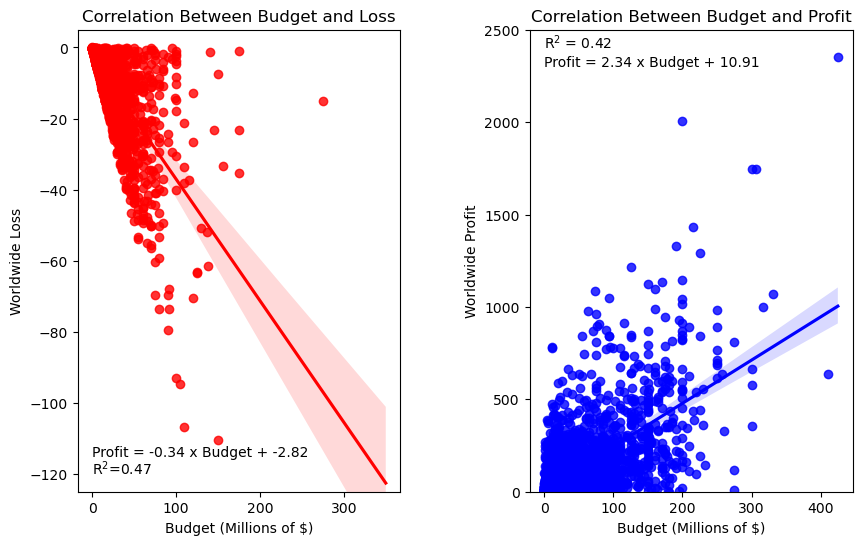

In [5]:
fig,[ax1,ax2] = plt.subplots(ncols=2,figsize=(10,6),gridspec_kw={'wspace':0.4})

p = sns.regplot(x=tn_loss['production_budget']/10**6,y=tn_loss['worldwide_net']/10**6,color='r',ax=ax1)
ax1.set_title('Correlation Between Budget and Loss')
ax1.set_xlabel('Budget (Millions of $)')
ax1.set_ylabel('Worldwide Loss')
ax1.set_ylim(-125,5)
slope, intercept, r, p_value1, sterr = stats.linregress(x=p.get_lines()[0].get_xdata(),
                                                        y=p.get_lines()[0].get_ydata())
X = np.array(tn_loss['production_budget']).reshape(-1, 1)  # Feature
y = np.array(tn_loss['worldwide_net'])  # Target

#Fit linear regression model
model = LinearRegression()
model.fit(X, y)

#predict and calculate R²
y_pred = model.predict(X)
r2_loss = r2_score(y, y_pred)

#add regression equation to plot
ax1.text(0, -120, f'R$^2$={r2_loss:.02f}')
ax1.text(0, -115, f'Profit = {slope:.02f} x Budget + {intercept:.02f}');

p = sns.regplot(x=tn_profit['production_budget']/10**6,y=tn_profit['worldwide_net']/10**6,color='b',ax=ax2)
ax2.set_ylim(0,2500)
ax2.set_title('Correlation Between Budget and Profit')
ax2.set_xlabel('Budget (Millions of $)')
ax2.set_ylabel('Worldwide Profit')
slope, intercept, r2, p_value2, sterr = stats.linregress(x=p.get_lines()[0].get_xdata(),
                                                         y=p.get_lines()[0].get_ydata())

X = np.array(tn_profit['production_budget']).reshape(-1, 1)  # Feature
y = np.array(tn_profit['worldwide_net'])  # Target

#Fit linear regression model
model = LinearRegression()
model.fit(X, y)

#predict and calculate R²
y_pred = model.predict(X)
r2_profit = r2_score(y, y_pred)
#Add correlation to plot
ax2.text(0, 2400, f'R$^2$ = {r2_profit:.02f}')
ax2.text(0, 2300, f'Profit = {slope:.02f} x Budget + {intercept:.02f}');
# print(p.get_lines()[0].get_ydata(),list(slope*tn_loss['production_budget']/10**6)+intercept)

Based on the determination that a higher budget does indeed correlate with higher profits and losses, we divide the dataset into 3 groups with same size based on their risk level:
- High risk invetsment, higher budget movies that will probably not have a very high ROI but have the chance of making large profit if audiences enjoy it;
- Low risk investment, a lower cost that can have a high ROI based on the lower investment;
- Medium risk investment, that is just inbetween.

We first filter the dataset starting from 2000 to onli pick up recent trends and calculate the 2 budget thresholds for each group.

In [6]:
tn_since2000 = tn[pd.to_datetime(tn['release_date']).dt.year>=2000]
tn_since2000

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI
4081,2010-05-21,Perrierâs Bounty,6600000,828,828,2010,-6599172,-0.999875
3818,2015-05-08,Skin Trade,9000000,1242,1242,2015,-8998758,-0.999862
1242,2013-11-01,Mr. Nobody,46500000,3622,22254,2013,-46477746,-0.999521
5298,2002-12-13,The Jimmy Show,1000000,703,703,2002,-999297,-0.999297
5297,2006-04-21,In Her Line of Fire,1000000,884,884,2006,-999116,-0.999116
...,...,...,...,...,...,...,...,...
5656,2007-05-16,Once,150000,9445857,23323631,2007,23173631,154.490873
5781,2005-08-05,My Date With Drew,1100,181041,181041,2005,179941,163.582727
5709,2004-05-07,Super Size Me,65000,11529368,22233808,2004,22168808,341.058585
5679,2015-07-10,The Gallows,100000,22764410,41656474,2015,41556474,415.564740


In [7]:
# We will work with 2 thresholds for our analysis
budget = tn_since2000['production_budget'].sort_values()
n_budget = len(budget)
threshold_budget_low = budget.iloc[int(n_budget/3)]
threshold_budget_high = budget.iloc[int(2*n_budget/3)]
print(f'The threshold in between low and medium risk is at ${threshold_budget_low/10**6:.02f} \
millions and in between medium and high is ${threshold_budget_high/10**6:0.2f} millions.')

The threshold in between low and medium risk is at $11.50 millions and in between medium and high is $36.00 millions.


In [8]:
tn_low_risk  = tn_since2000[tn_since2000['production_budget']<=threshold_budget_low]
tn_medium_risk = tn_since2000[(tn_since2000['production_budget']>threshold_budget_low) & (tn_since2000['production_budget']<threshold_budget_high)]
tn_high_risk = tn_since2000[tn_since2000['production_budget']>=threshold_budget_high]

0.611615 15.943401 85.08081


Text(335, 100, 'High Hisk Median Profit (~$85 Million)')

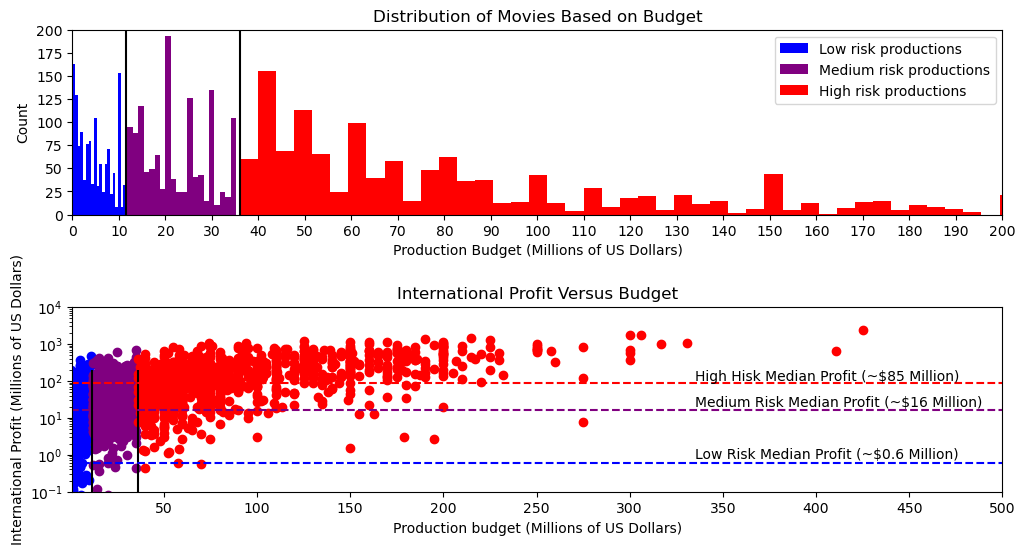

In [9]:
fig, ax = plt.subplots(nrows=2, figsize=(12,6), gridspec_kw={'hspace': 0.5})
# fig.tight_layout()


median_profit_low = tn_low_risk['worldwide_net'].median()/10**6
median_profit_medium = tn_medium_risk['worldwide_net'].median()/10**6
median_profit_high = tn_high_risk['worldwide_net'].median()/10**6
print(median_profit_low, median_profit_medium, median_profit_high)

ax[0].hist(tn_low_risk['production_budget']/10**6, color='b',bins=20, label='Low risk productions')
ax[0].hist(tn_medium_risk['production_budget']/10**6, color='purple',bins=20, label='Medium risk productions')
ax[0].hist(tn_high_risk['production_budget']/10**6, color='r',bins=100, label='High risk productions');
ax[0].set_yticks(np.arange(0,201,25))
ax[0].set_ylim(0,200)
ax[0].set_xticks(np.arange(0,501,10))
ax[0].set_xlim(0,200)
ax[0].set_xlabel('Production Budget (Millions of US Dollars)')
ax[0].set_ylabel('Count')
ax[0].legend()
ax[0].set_title('Distribution of Movies Based on Budget')
ax[0].vlines(x=threshold_budget_low/10**6,ymin=0,ymax=200,color='black')
# ax[0].text(x=threshold_budget_low/10**6,y=175,s='Median budget')
ax[0].vlines(x=threshold_budget_high/10**6,ymin=0,ymax=200,color='black')
# ax[0].text(x=threshold_budget_high,y=175,s='Median budget')

ax[1].scatter(x=tn_low_risk['production_budget']/10**6, y=tn_low_risk['worldwide_net']/10**6,color='b',label='Low risk productions')
ax[1].scatter(x=tn_medium_risk['production_budget']/10**6, y=tn_medium_risk['worldwide_net']/10**6,color='purple',label='Medium risk productions')
ax[1].scatter(x=tn_high_risk['production_budget']/10**6, y=tn_high_risk['worldwide_net']/10**6, color='r', label='High risk productions')
ax[1].set_title('International Profit Versus Budget')
ax[1].set_xlabel('Production budget (Millions of US Dollars)')
ax[1].set_ylabel('International Profit (Millions of US Dollars)')
ax[1].set_yticks(np.arange(0,1000,25))
ax[1].set_ylim(0.1,10000)
ax[1].set_xticks(np.arange(0,501,50))
ax[1].set_xlim(1,500)
ax[1].vlines(x=threshold_budget_low/10**6,ymin=0,ymax=200,color='black')
ax[1].vlines(x=threshold_budget_high/10**6,ymin=0,ymax=200,color='black')
ax[1].hlines(xmin=0,xmax=500,y=median_profit_low,color='blue', linestyle='dashed')
ax[1].hlines(xmin=0,xmax=500,y=median_profit_medium,color='purple', linestyle='dashed')
ax[1].hlines(xmin=0,xmax=500,y=median_profit_high,color='red', linestyle='dashed')
ax[1].set_yscale('log')
ax[1].text(x=335,y=0.8,s='Low Risk Median Profit (~$0.6 Million)')
ax[1].text(x=335,y=20,s='Medium Risk Median Profit (~$16 Million)')
ax[1].text(x=335,y=100,s='High Hisk Median Profit (~$85 Million)')

# ax[1].text(x=21,y=2000,s='Median Profit for Low Risk Movie')

# Low Risk - Budget < $11.50 millions

The first thing we need to do is join the table with budgets and profit with the table that contains genres. Genres are in both IMDB and Movie DB meaning that in order to lose the least amount of information, we need to perform joins with different tables, concatenate and remove duplicates.

In [10]:
tn_low_risk

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI
4081,2010-05-21,Perrierâs Bounty,6600000,828,828,2010,-6599172,-0.999875
3818,2015-05-08,Skin Trade,9000000,1242,1242,2015,-8998758,-0.999862
5298,2002-12-13,The Jimmy Show,1000000,703,703,2002,-999297,-0.999297
5297,2006-04-21,In Her Line of Fire,1000000,884,884,2006,-999116,-0.999116
3728,2009-10-16,Janky Promoters,10000000,9069,9069,2009,-9990931,-0.999093
...,...,...,...,...,...,...,...,...
5656,2007-05-16,Once,150000,9445857,23323631,2007,23173631,154.490873
5781,2005-08-05,My Date With Drew,1100,181041,181041,2005,179941,163.582727
5709,2004-05-07,Super Size Me,65000,11529368,22233808,2004,22168808,341.058585
5679,2015-07-10,The Gallows,100000,22764410,41656474,2015,41556474,415.564740


In [11]:
# Create a temporary file
with tempfile.NamedTemporaryFile(delete=False) as temp_db:
    # Extract the database file from the zip archive to the temporary file
    with zipfile.ZipFile('zippedData/im.db.zip', 'r') as z:
        with z.open('im.db') as f:
            temp_db.write(f.read())
    temp_db_path = temp_db.name
conn = sqlite3.connect(temp_db_path)

imdb = pd.read_sql(
    """
    SELECT  mb.primary_title AS movie,
            mb.start_year, 
            mb.runtime_minutes, 
            mb.genres, 
            per.primary_name AS director
    FROM movie_basics AS mb
    JOIN movie_akas AS ma
    USING(movie_id)
    JOIN directors AS dir
    USING(movie_id)
    JOIN persons AS per
    USING(person_id)
    GROUP BY movie_id
    
    """
, conn
)
imdb

,movie,start_year,runtime_minutes,genres,director
0,Sunghursh,2013,175.0,"Action,Crime,Drama",Harnam Singh Rawail
1,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",Mani Kaul
2,The Other Side of the Wind,2018,122.0,Drama,Orson Welles
3,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",Hrishikesh Mukherjee
4,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",Raoul Ruiz
...,...,...,...,...,...
119436,Padmavyuhathile Abhimanyu,2019,130.0,Drama,Vineesh Aaradya
119437,Nepal - Homebird,2019,52.0,Documentary,Andrea Leichtfried
119438,A Cherry Tale,2019,85.0,Documentary,Eva Mulvad
119439,Vida em Movimento,2019,70.0,Documentary,Eduardo Rajabally


In [12]:
genre_dict = {
    '28': 'Action',
    '12': 'Adventure',
    '16': 'Animation',
    '35': 'Comedy',
    '80': 'Crime',
    '99': 'Documentary',
    '18': 'Drama',
    '10751': 'Family',
    '14': 'Fantasy',
    '36': 'History',
    '27': 'Horror',
    '10402': 'Music',
    '9648': 'Mystery',
    '10749': 'Romance',
    '878': 'Science Fiction',
    '10770': 'TV Movie',
    '53': 'Thriller',
    '10752': 'War',
    '37': 'Western'
}

In [13]:
movie_db = pd.read_csv('zippedData/tmdb.movies.csv')
movie_db['genre_ids'] = movie_db['genre_ids'].replace({'\[': '', '\]': ''}, regex=True)
movie_db['genre_ids'] = movie_db['genre_ids'].str.split(',')
movie_db = movie_db.explode('genre_ids')
movie_db['genre_ids'] = movie_db['genre_ids'].apply(clean_object)
movie_db['genre_ids'] = movie_db['genre_ids'].map(genre_dict)
movie_db.drop(labels=['Unnamed: 0', 'id', 'original_language', 'popularity', 'release_date','vote_average', 'vote_count'],axis=1,inplace=True)
movie_db.rename(columns={'title':'movie','genre_ids':'genres'},inplace=True)
movie_db

,genres,original_title,movie
0,Adventure,Harry Potter and the Deathly Hallows: Part 1,Harry Potter and the Deathly Hallows: Part 1
0,Fantasy,Harry Potter and the Deathly Hallows: Part 1,Harry Potter and the Deathly Hallows: Part 1
0,Family,Harry Potter and the Deathly Hallows: Part 1,Harry Potter and the Deathly Hallows: Part 1
1,Fantasy,How to Train Your Dragon,How to Train Your Dragon
1,Adventure,How to Train Your Dragon,How to Train Your Dragon
...,...,...,...
26515,Family,Trailer Made,Trailer Made
26515,Adventure,Trailer Made,Trailer Made
26515,Action,Trailer Made,Trailer Made
26516,Thriller,The Church,The Church


In [14]:
df_lowrisk_merged1 = pd.merge(tn_low_risk,movie_db,how='inner',on='movie')
df_lowrisk_merged1.drop_duplicates(subset=['release_date','genres','movie'], inplace=True)
df_lowrisk_merged1.drop('original_title', axis=1, inplace=True)
df_lowrisk_merged1.dropna(subset=['genres', 'worldwide_net', 'movie','production_budget'],inplace=True)
df_lowrisk_merged1

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,genres
0,2015-05-08,Skin Trade,9000000,1242,1242,2015,-8998758,-0.999862,Thriller
1,2015-05-08,Skin Trade,9000000,1242,1242,2015,-8998758,-0.999862,Action
2,2015-05-08,Skin Trade,9000000,1242,1242,2015,-8998758,-0.999862,Drama
4,2018-05-11,Higher Power,500000,528,528,2018,-499472,-0.998944,Action
5,2018-05-11,Higher Power,500000,528,528,2018,-499472,-0.998944,Science Fiction
...,...,...,...,...,...,...,...,...,...
1314,2009-04-23,Home,500000,15433,44793168,2009,44293168,88.586336,Horror
1319,2012-01-06,The Devil Inside,1000000,53262945,101759490,2012,100759490,100.759490,Thriller
1320,2012-01-06,The Devil Inside,1000000,53262945,101759490,2012,100759490,100.759490,Horror
1321,2015-07-10,The Gallows,100000,22764410,41656474,2015,41556474,415.564740,Horror


In [15]:
df_lowrisk_merged2 = pd.merge(left=tn_low_risk, right=movie_db,how='inner',left_on='movie', right_on='original_title')
df_lowrisk_merged2.drop_duplicates(subset=['release_date','genres','movie_x'], inplace=True)
df_lowrisk_merged2.rename(columns={'movie_x':'movie'},inplace=True)
df_lowrisk_merged2.drop(['original_title', 'movie_y'],axis=1,inplace=True)
df_lowrisk_merged2.dropna(subset=['genres', 'worldwide_net', 'movie','production_budget'],inplace=True)
df_lowrisk_merged2

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,genres
0,2015-05-08,Skin Trade,9000000,1242,1242,2015,-8998758,-0.999862,Thriller
1,2015-05-08,Skin Trade,9000000,1242,1242,2015,-8998758,-0.999862,Action
2,2015-05-08,Skin Trade,9000000,1242,1242,2015,-8998758,-0.999862,Drama
4,2018-05-11,Higher Power,500000,528,528,2018,-499472,-0.998944,Action
5,2018-05-11,Higher Power,500000,528,528,2018,-499472,-0.998944,Science Fiction
...,...,...,...,...,...,...,...,...,...
1296,2009-04-23,Home,500000,15433,44793168,2009,44293168,88.586336,Drama
1300,2012-01-06,The Devil Inside,1000000,53262945,101759490,2012,100759490,100.759490,Thriller
1301,2012-01-06,The Devil Inside,1000000,53262945,101759490,2012,100759490,100.759490,Horror
1302,2015-07-10,The Gallows,100000,22764410,41656474,2015,41556474,415.564740,Horror


In [16]:
df_lowrisk_merged3 = pd.merge(tn_low_risk,imdb,how='inner',on='movie')
df_lowrisk_merged3.drop_duplicates(subset=['release_date','movie'], inplace=True)
df_lowrisk_merged3.drop(['runtime_minutes', 'start_year','director'], axis=1, inplace=True)
df_lowrisk_merged3.dropna(subset=['genres', 'worldwide_net', 'movie','production_budget'],inplace=True)
df_lowrisk_merged3

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,genres
0,2015-05-08,Skin Trade,9000000,1242,1242,2015,-8998758,-0.999862,Documentary
2,2018-05-11,Higher Power,500000,528,528,2018,-499472,-0.998944,"Action,Sci-Fi,Thriller"
3,2013-02-22,Inescapable,4000000,4327,4327,2013,-3995673,-0.998918,"Action,Drama,Mystery"
4,2013-04-05,Eddie: The Sleepwalking Cannibal,1400000,1632,1632,2013,-1398368,-0.998834,"Comedy,Horror"
5,2012-10-26,The Ghastly Love of Johnny X,2000000,2436,2436,2012,-1997564,-0.998782,"Comedy,Fantasy,Musical"
...,...,...,...,...,...,...,...,...,...
838,2015-04-17,Unfriended,1000000,32789645,64364198,2015,63364198,63.364198,"Horror,Mystery,Thriller"
839,2011-04-01,Insidious,1500000,54009150,99870886,2011,98370886,65.580591,"Horror,Mystery,Thriller"
840,2009-04-23,Home,500000,15433,44793168,2009,44293168,88.586336,Drama
860,2012-01-06,The Devil Inside,1000000,53262945,101759490,2012,100759490,100.759490,Horror


We explode the lists with the genres so that movies might be duplicate buteach entry will have a diffrent genre it is part of.

In [17]:
df_lowrisk_merged3['genres'] = df_lowrisk_merged3['genres'].str.split(',')
df_lowrisk_merged3 = df_lowrisk_merged3.explode('genres')
# df_lowrisk_merged3['genres'].value_counts()

In [18]:
df_lowrisk_exploded = pd.concat([df_lowrisk_merged1,df_lowrisk_merged2,df_lowrisk_merged3])
df_lowrisk_exploded.drop_duplicates(subset=['release_date','movie','genres'], inplace=True)
df_lowrisk_exploded['genres'].value_counts()

genres
Drama              413
Comedy             192
Thriller           176
Horror             127
Romance            113
Mystery             96
Crime               84
Action              67
Documentary         66
Biography           52
Science Fiction     40
Fantasy             36
Music               36
Adventure           34
Family              32
Sci-Fi              28
History             27
War                 16
Sport               13
Animation            9
Western              7
Musical              5
Name: count, dtype: int64

Finally, we rename same genres written diffrently.

In [19]:
df_lowrisk_exploded['genres'].replace(to_replace='Science Fiction', value='Sci-Fi',inplace=True)
df_lowrisk_exploded['genres'].value_counts()

/tmp/ipykernel_102626/4107546668.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_lowrisk_exploded['genres'].replace(to_replace='Science Fiction', value='Sci-Fi',inplace=True)


genres
Drama          413
Comedy         192
Thriller       176
Horror         127
Romance        113
Mystery         96
Crime           84
Sci-Fi          68
Action          67
Documentary     66
Biography       52
Music           36
Fantasy         36
Adventure       34
Family          32
History         27
War             16
Sport           13
Animation        9
Western          7
Musical          5
Name: count, dtype: int64

## Low Risk - Genre

Finally, the dataframe has now all the information from genres and movies we need.

In [20]:
df_lowrisk_exploded.groupby('genres')['ROI'].median().sort_values(ascending=False).reset_index().head()

,genres,ROI
0,Horror,4.163727
1,Mystery,3.810244
2,Sci-Fi,1.751043
3,Romance,1.036410
4,Thriller,0.999622


In [21]:
df_lowrisk_exploded.groupby('genres')['worldwide_net'].median().sort_values(ascending=False).reset_index().head()

,genres,worldwide_net
0,Horror,15434588.0
1,Mystery,14371155.5
2,Romance,2681937.0
3,Fantasy,2438210.0
4,Thriller,1889796.0


Horror and Mystery have very similar ROI's and international profits. In order to determine which is more profitable, we use a t-test.

In [22]:
mean_horror = df_lowrisk_exploded[df_lowrisk_exploded['genres']=='Horror']['worldwide_net'].mean()/10**6
std_horror = df_lowrisk_exploded[df_lowrisk_exploded['genres']=='Horror']['worldwide_net'].std()/10**6
n_horror = len(df_lowrisk_exploded[df_lowrisk_exploded['genres']=='Horror']['worldwide_net'])

t_horror_20 = (20-mean_horror)/(std_horror/n_horror**0.5)
t_horror_35 = (35-mean_horror)/(std_horror/n_horror**0.5)
t_horror_50 = (50-mean_horror)/(std_horror/n_horror**0.5)
print(f'T scores for profit of: \n$20 million = {t_horror_20}\n$35 million = {t_horror_35}\n$50 million = {t_horror_50}\n')

prob_horror_20 = 1-stats.t.cdf(t_horror_20,df=n_horror-1)
prob_horror_35 = 1-stats.t.cdf(t_horror_35,df=n_horror-1)
prob_horror_50 = 1-stats.t.cdf(t_horror_50,df=n_horror-1)
print(f'Probability for profit of: \n$20 million = {prob_horror_20}\n$35 million = {prob_horror_35}\n$50 million = {prob_horror_50}')

horror_avg_cost = df_lowrisk_exploded[df_lowrisk_exploded['genres'] == 'Horror']['production_budget'].mean()
print(f'Average cost of Horror movies below ${threshold_budget_low/10**6:0.2f} million are ${horror_avg_cost/10**6:.02f} millions')

T scores for profit of: 
$20 million = -3.6017645678829213
$35 million = -0.6797071532264725
$50 million = 2.242350261429976

Probability for profit of: 
$20 million = 0.9997733937949502
$35 million = 0.7510316219789762
$50 million = 0.013343571801237686
Average cost of Horror movies below $11.50 million are $4.51 millions


In [23]:
mean_mystery = df_lowrisk_exploded[df_lowrisk_exploded['genres']=='Mystery']['worldwide_net'].mean()/10**6
std_mystery = df_lowrisk_exploded[df_lowrisk_exploded['genres']=='Mystery']['worldwide_net'].std()/10**6
n_mystery = len(df_lowrisk_exploded[df_lowrisk_exploded['genres']=='Mystery']['worldwide_net'])

t_mystery_20 = (20-mean_mystery)/(std_mystery/n_mystery**0.5)
t_mystery_35 = (35-mean_mystery)/(std_mystery/n_mystery**0.5)
t_mystery_50 = (50-mean_mystery)/(std_mystery/n_mystery**0.5)
print(f'T scores for profit of: \n$20 million = {t_mystery_20}\n$35 million = {t_mystery_35}\n$50 million = {t_mystery_50}\n')

prob_mystery_20 = 1-stats.t.cdf(t_mystery_20,df=n_mystery-1)
prob_mystery_35 = 1-stats.t.cdf(t_mystery_35,df=n_mystery-1)
prob_mystery_50 = 1-stats.t.cdf(t_mystery_50,df=n_mystery-1)
print(f'Probability for profit f: \n$20 million = {prob_mystery_20}\n$35 million = {prob_mystery_35}\n$50 million = {prob_mystery_50}')

mystery_avg_cost = df_lowrisk_exploded[df_lowrisk_exploded['genres'] == 'Mystery']['production_budget'].mean()
print(f'Average cost of Mystery movies below ${threshold_budget_low/10**6:0.2f} million are ${mystery_avg_cost/10**6:.02f} millions')

T scores for profit of: 
$20 million = -2.769851906203676
$35 million = 0.009069978403655641
$50 million = 2.7879918630109874

Probability for profit f: 
$20 million = 0.9966272916473534
$35 million = 0.49639116153943286
$50 million = 0.003203179748977769
Average cost of Mystery movies below $11.50 million are $4.97 millions


### This means that Horror movies will cost about the same and will have a higher chance of getting more profit.

## Low Risk - Director

Knowing which genre is more profitable, we need to choose directors who succed in making profitable horror movies. For this, we do not restrict the detaframe to early releases.

In [24]:
df_merged = pd.merge(tn,imdb,how='inner',on='movie')
df_merged.drop_duplicates(subset=['release_date','movie'], inplace=True)
df_merged['genres'] = df_merged['genres'].str.split(',')
df_merged = df_merged.explode(column='genres')
df_horror = df_merged[df_merged['genres']=='Horror']
df_horror = df_horror[df_horror['production_budget']<=threshold_budget_low]
df_horror.sort_values(by='worldwide_net',ascending=False)

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,start_year,runtime_minutes,genres,director
2884,2017-02-24,Get Out,5000000,176040665,255367951,2017,250367951,50.073590,2017,104.0,Horror,Jordan Peele
2879,2014-10-03,Annabelle,6500000,84273813,256862920,2014,250362920,38.517372,2014,99.0,Horror,John R. Leonetti
2845,2018-10-19,Halloween,10000000,159342015,254900667,2018,244900667,24.490067,2018,106.0,Horror,David Gordon Green
2880,2011-10-21,Paranormal Activity 3,5000000,104028807,207039844,2011,202039844,40.407969,2011,83.0,Horror,Henry Joost
2891,2010-10-20,Paranormal Activity 2,3000000,84752907,177512032,2010,174512032,58.170677,2010,91.0,Horror,Tod Williams
...,...,...,...,...,...,...,...,...,...,...,...,...
294,2003-10-03,Wonderland,5500000,1060512,1060512,2003,-4439488,-0.807180,2011,80.0,Horror,Brandon Slagle
330,2009-05-08,Julia,6000000,65108,1365108,2009,-4634892,-0.772482,2014,95.0,Horror,Matthew A. Brown
12,2009-08-14,Grace,5000000,8297,8297,2009,-4991703,-0.998341,2011,98.0,Horror,Rodger Edralin
10,2015-05-15,Area 51,5000000,7556,7556,2015,-4992444,-0.998489,2015,91.0,Horror,Oren Peli


In [25]:
director_horror = df_horror.groupby('director')['worldwide_net'].mean().sort_values(ascending=False).reset_index()
director_horror.head(10)

,director,worldwide_net
0,Jordan Peele,250367951.0
1,John R. Leonetti,250362920.0
2,Tod Williams,174512032.0
3,Henry Joost,169928918.0
4,Adam Robitel,157885588.0
5,David Gordon Green,157287833.5
6,Gil Kenan,111006019.0
7,Dan Trachtenberg,103286422.0
8,William Brent Bell,100759490.0
9,James DeMonaco,99772063.0


In [26]:
df_horror[df_horror['director'].isin(director_horror['director'].loc[:5])].sort_values('director')

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,start_year,runtime_minutes,genres,director
2814,2018-01-05,Insidious: The Last Key,10000000,67745330,167885588,2018,157885588,15.788559,2018,103.0,Horror,Adam Robitel
2845,2018-10-19,Halloween,10000000,159342015,254900667,2018,244900667,24.490067,2018,106.0,Horror,David Gordon Green
2923,1978-10-17,Halloween,325000,47000000,70000000,1978,69675000,214.384615,2018,106.0,Horror,David Gordon Green
2856,2012-10-19,Paranormal Activity 4,5000000,53900335,142817992,2012,137817992,27.563598,2012,88.0,Horror,Henry Joost
2880,2011-10-21,Paranormal Activity 3,5000000,104028807,207039844,2011,202039844,40.407969,2011,83.0,Horror,Henry Joost
2879,2014-10-03,Annabelle,6500000,84273813,256862920,2014,250362920,38.517372,2014,99.0,Horror,John R. Leonetti
2884,2017-02-24,Get Out,5000000,176040665,255367951,2017,250367951,50.073590,2017,104.0,Horror,Jordan Peele
2891,2010-10-20,Paranormal Activity 2,3000000,84752907,177512032,2010,174512032,58.170677,2010,91.0,Horror,Tod Williams


### For the animation movie, we recommend the directors:
- Jordan Peele;
- John R. Leonetti.

## Low risk - Release Month

In [27]:
df_horror['release_month'] = pd.to_datetime(df_horror['release_date'], format='%m').dt.month
df_horror.drop('release_date',axis=1,inplace=True)
df_horror.head()

,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,start_year,runtime_minutes,genres,director,release_month
7,Eddie: The Sleepwalking Cannibal,1400000,1632,1632,2013,-1398368,-0.998834,2012,90.0,Horror,Boris Rodriguez,4
10,Area 51,5000000,7556,7556,2015,-4992444,-0.998489,2015,91.0,Horror,Oren Peli,5
12,Grace,5000000,8297,8297,2009,-4991703,-0.998341,2011,98.0,Horror,Rodger Edralin,8
35,Circle,2000000,10024,10024,2010,-1989976,-0.994988,2010,88.0,Horror,Michael W. Watkins,8
51,Blood Feast,1200000,8708,8708,2018,-1191292,-0.992743,2016,90.0,Horror,Marcel Walz,2


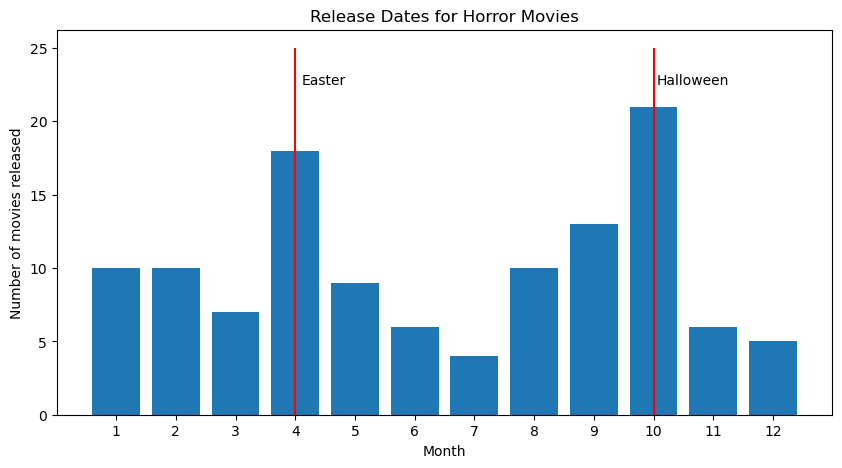

In [28]:
horror_month_release = df_horror.groupby('release_month')['movie'].count().reset_index()

fig,ax = plt.subplots(figsize=(10,5))

ax.bar(x='release_month',height='movie',data=horror_month_release);
ax.set_xticks(np.arange(1,13,1))
ax.set_yticks(np.arange(0,30,5))
ax.set_xlabel('Month')
ax.set_ylabel('Number of movies released');
# ax.vlines(x=2,ymin=0,ymax=18, color='r')
ax.vlines(x=4,ymin=0,ymax=25, color='r')
ax.vlines(x=10,ymin=0,ymax=25, color='r')
# ax.text(x=2.1,y=17, s='Spring Break')
ax.text(x=4.1,y=22.5, s='Easter')
ax.text(x=10.05,y=22.5, s='Halloween')
ax.set_title('Release Dates for Horror Movies');

Two options of release dates.
- April - Easter: a lot of Horror movies have religious subtext;
- November - Halloween.

We recommend releasing the movie during Halloween.

## Low risk - Runtime

In [29]:
n_horror = len(df_horror['runtime_minutes'].dropna())
mean_horror = df_horror['runtime_minutes'].dropna().mean()
std_horror = df_horror['runtime_minutes'].dropna().std()
Tcrit = stats.t.ppf(0.975,n_horror-1)

runtime_horror_low = mean_horror - Tcrit*std_horror/n_horror**0.5
runtime_horror_up = mean_horror + Tcrit*std_horror/n_horror**0.5

print(f'Runtime should be around {round(runtime_horror_low)} to {ceil(runtime_horror_up)} minutes')


Runtime should be around 93 to 98 minutes


# Medium Risk

We now repeat the same steps with medium risk budgets.

In [30]:
df_mediumrisk_merged1 = pd.merge(tn_medium_risk,movie_db,how='inner',on='movie')
df_mediumrisk_merged1.drop_duplicates(subset=['release_date','genres','movie'], inplace=True)
df_mediumrisk_merged1.drop('original_title', axis=1, inplace=True)
df_mediumrisk_merged1

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,genres
0,2015-11-11,10 Days in a Madhouse,12000000,14616,14616,2015,-11985384,-0.998782,Drama
1,2015-10-30,Freaks of Nature,33000000,70958,70958,2015,-32929042,-0.997850,Science Fiction
2,2015-10-30,Freaks of Nature,33000000,70958,70958,2015,-32929042,-0.997850,Comedy
3,2015-10-30,Freaks of Nature,33000000,70958,70958,2015,-32929042,-0.997850,Horror
7,2013-09-06,Winnie Mandela,15000000,61847,61847,2013,-14938153,-0.995877,Drama
...,...,...,...,...,...,...,...,...,...
1378,2016-12-09,La La Land,20000000,151101803,426351163,2016,406351163,20.317558,Romance
1382,2010-12-03,Black Swan,13000000,106954678,331266710,2010,318266710,24.482055,Drama
1383,2010-12-03,Black Swan,13000000,106954678,331266710,2010,318266710,24.482055,Thriller
1384,2014-06-06,The Fault in Our Stars,12000000,124872350,307166834,2014,295166834,24.597236,Romance


In [31]:
df_mediumrisk_merged2 = pd.merge(left=tn_medium_risk, right=movie_db,how='inner',left_on='movie', right_on='original_title')
df_mediumrisk_merged2.drop_duplicates(subset=['release_date','genres','movie_x'], inplace=True)
df_mediumrisk_merged2.rename(columns={'movie_x':'movie'},inplace=True)
df_mediumrisk_merged2.drop(['original_title', 'movie_y'],axis=1,inplace=True)
df_mediumrisk_merged2

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,genres
0,2015-11-11,10 Days in a Madhouse,12000000,14616,14616,2015,-11985384,-0.998782,Drama
1,2015-10-30,Freaks of Nature,33000000,70958,70958,2015,-32929042,-0.997850,Science Fiction
2,2015-10-30,Freaks of Nature,33000000,70958,70958,2015,-32929042,-0.997850,Comedy
3,2015-10-30,Freaks of Nature,33000000,70958,70958,2015,-32929042,-0.997850,Horror
7,2013-09-06,Winnie Mandela,15000000,61847,61847,2013,-14938153,-0.995877,Drama
...,...,...,...,...,...,...,...,...,...
1329,2016-12-09,La La Land,20000000,151101803,426351163,2016,406351163,20.317558,Romance
1333,2010-12-03,Black Swan,13000000,106954678,331266710,2010,318266710,24.482055,Drama
1334,2010-12-03,Black Swan,13000000,106954678,331266710,2010,318266710,24.482055,Thriller
1335,2014-06-06,The Fault in Our Stars,12000000,124872350,307166834,2014,295166834,24.597236,Romance


In [32]:
df_mediumrisk_merged3 = pd.merge(tn_medium_risk,imdb,how='inner',on='movie')
df_mediumrisk_merged3.drop_duplicates(subset=['release_date','movie'], inplace=True)
df_mediumrisk_merged3.drop(['runtime_minutes', 'start_year','director'], axis=1, inplace=True)
df_mediumrisk_merged3

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,genres
0,2015-11-11,10 Days in a Madhouse,12000000,14616,14616,2015,-11985384,-0.998782,Drama
1,2015-10-30,Freaks of Nature,33000000,70958,70958,2015,-32929042,-0.997850,"Comedy,Horror,Sci-Fi"
2,2013-09-06,Winnie Mandela,15000000,61847,61847,2013,-14938153,-0.995877,"Biography,Drama,History"
3,2015-06-05,United Passions,30000000,918,168832,2015,-29831168,-0.994372,"Drama,History,Sport"
4,2010-06-30,Love Ranch,25000000,137885,146149,2010,-24853851,-0.994154,"Biography,Comedy,Drama"
...,...,...,...,...,...,...,...,...,...
862,2017-09-08,It,35000000,327481748,697457969,2017,662457969,18.927371,"Horror,Thriller"
863,2017-08-11,Annabelle: Creation,15000000,102092201,305384865,2017,290384865,19.358991,"Horror,Mystery,Thriller"
864,2016-12-09,La La Land,20000000,151101803,426351163,2016,406351163,20.317558,"Comedy,Drama,Music"
865,2010-12-03,Black Swan,13000000,106954678,331266710,2010,318266710,24.482055,"Drama,Thriller"


In [33]:
df_mediumrisk_merged3['genres'] = df_mediumrisk_merged3['genres'].str.split(',')
df_mediumrisk_merged3 = df_mediumrisk_merged3.explode('genres')
df_mediumrisk_merged3['genres'].value_counts()

genres
Drama          348
Comedy         191
Action         110
Crime          109
Thriller        96
Romance         94
Biography       69
Horror          55
Adventure       52
Mystery         37
Documentary     35
Sci-Fi          29
Family          27
Fantasy         26
Music           23
History         22
Sport           17
War             14
Animation       11
Western          3
Musical          1
Name: count, dtype: int64

In [34]:
df_mediumrisk_exploded = pd.concat([df_mediumrisk_merged1, df_mediumrisk_merged2, df_mediumrisk_merged3])
df_mediumrisk_exploded.drop_duplicates(subset=['release_date','movie','genres'], inplace=True)
df_mediumrisk_exploded['genres'].value_counts()

genres
Drama              394
Comedy             213
Thriller           183
Crime              132
Action             132
Romance            113
Horror              74
Biography           69
Adventure           65
Mystery             59
History             45
Family              44
Documentary         42
Science Fiction     38
Fantasy             35
Sci-Fi              29
Music               28
War                 24
Sport               17
Animation           16
Western              5
TV Movie             1
Musical              1
Name: count, dtype: int64

In [35]:
df_mediumrisk_exploded['genres'].replace(to_replace='Science Fiction', value='Sci-Fi',inplace=True)
df_mediumrisk_exploded['genres'].value_counts()

/tmp/ipykernel_102626/381516847.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_mediumrisk_exploded['genres'].replace(to_replace='Science Fiction', value='Sci-Fi',inplace=True)


genres
Drama          394
Comedy         213
Thriller       183
Crime          132
Action         132
Romance        113
Horror          74
Biography       69
Sci-Fi          67
Adventure       65
Mystery         59
History         45
Family          44
Documentary     42
Fantasy         35
Music           28
War             24
Sport           17
Animation       16
Western          5
TV Movie         1
Musical          1
Name: count, dtype: int64

## Medium Risk - Genre

In [36]:
df_mediumrisk_exploded.groupby('genres')['worldwide_net'].count().sort_values(ascending=False).reset_index()

,genres,worldwide_net
0,Drama,394
1,Comedy,213
2,Thriller,183
3,Action,132
4,Crime,132
5,Romance,113
6,Horror,74
7,Biography,69
8,Sci-Fi,67
9,Adventure,65


In [37]:
df_mediumrisk_exploded['genres'].replace(to_replace='Musical', value='Music')
df_mediumrisk_exploded = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']!='TV Movie']

In [38]:
df_mediumrisk_exploded.groupby('genres')['worldwide_net'].median().sort_values(ascending=False).reset_index().head(10)

,genres,worldwide_net
0,Horror,32003693.5
1,Music,29954085.5
2,Comedy,28527161.0
3,Fantasy,27427346.0
4,Adventure,27427346.0
5,Family,27222287.0
6,Romance,26627836.0
7,Documentary,23277674.0
8,Biography,20044909.0
9,Thriller,18293628.0


In [39]:
#Let us calculate the probability that an horror and horror movie will make profits
mean_horror = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Horror']['worldwide_net'].mean()/10**6
std_horror = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Horror']['worldwide_net'].std()/10**6
n_horror = len(df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Horror']['worldwide_net'])

t_horror_1 = (20-mean_horror)/(std_horror/n_horror**0.5)
t_horror_2 = (40-mean_horror)/(std_horror/n_horror**0.5)
t_horror_3 = (60-mean_horror)/(std_horror/n_horror**0.5)
t_horror_4 = (80-mean_horror)/(std_horror/n_horror**0.5)
print(f'T scores for profit of: \n$20 million = {t_horror_1}\n$40 million = {t_horror_2}\n$60 million = {t_horror_3}\n$80 million = {t_horror_4}\n')

prob_horror_1 = 1-stats.t.cdf(t_horror_1,df=n_horror-1)
prob_horror_2 = 1-stats.t.cdf(t_horror_2,df=n_horror-1)
prob_horror_3 = 1-stats.t.cdf(t_horror_3,df=n_horror-1)
prob_horror_4 = 1-stats.t.cdf(t_horror_4,df=n_horror-1)
print(f'Probability for profit f: \n$20 million = {prob_horror_1}\n$40 million = {prob_horror_2}\n$60 million = {prob_horror_3}\n$80 million = {prob_horror_4}\n')

horror_avg_cost = df_mediumrisk_exploded[df_mediumrisk_exploded['genres'] == 'Horror']['production_budget'].mean()
print(f'Average cost of horror movies above ${threshold_budget_low/10**6:0.02f} millions but below ${threshold_budget_high/10**6} \
millions are ${horror_avg_cost/10**6:.02f} millions')

T scores for profit of: 
$20 million = -2.9818762248564195
$40 million = -1.2232467444970372
$60 million = 0.5353827358623451
$80 million = 2.2940122162217276

Probability for profit f: 
$20 million = 0.9980541488043901
$40 million = 0.88741469485021
$60 million = 0.2970062721670568
$80 million = 0.012334480186491636

Average cost of horror movies above $11.50 millions but below $36.0 millions are $22.15 millions


In [40]:
#Let us calculate the probability that an music and music movie will make profits
mean_music = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Music']['worldwide_net'].mean()/10**6
std_music = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Music']['worldwide_net'].std()/10**6
n_music = len(df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Music']['worldwide_net'])

t_music_1 = (20-mean_music)/(std_music/n_music**0.5)
t_music_2 = (40-mean_music)/(std_music/n_music**0.5)
t_music_3 = (60-mean_music)/(std_music/n_music**0.5)
t_music_4 = (80-mean_music)/(std_music/n_music**0.5)
print(f'T scores for profit of: \n$20 million = {t_music_1}\n$40 million = {t_music_2}\n$60 million = {t_music_3}\n$80 million = {t_music_4}\n')

prob_music_1 = 1-stats.t.cdf(t_music_1,df=n_music-1)
prob_music_2 = 1-stats.t.cdf(t_music_2,df=n_music-1)
prob_music_3 = 1-stats.t.cdf(t_music_3,df=n_music-1)
prob_music_4 = 1-stats.t.cdf(t_music_4,df=n_music-1)
print(f'Probability for profit f: \n$20 million = {prob_music_1}\n$40 million = {prob_music_2}\n$60 million = {prob_music_3}\n$80 million = {prob_music_4}\n')

music_avg_cost = df_mediumrisk_exploded[df_mediumrisk_exploded['genres'] == 'Music']['production_budget'].mean()
print(f'Average cost of Music movies above ${threshold_budget_low/10**6:0.02f} millions but below ${threshold_budget_high/10**6} \
millions are ${music_avg_cost/10**6:.02f} millions')

T scores for profit of: 
$20 million = -2.418205698375475
$40 million = -1.3112389607422235
$60 million = -0.20427222310897178
$80 million = 0.90269451452428

Probability for profit f: 
$20 million = 0.9886917795972838
$40 million = 0.8995902806067388
$60 million = 0.5801636239084736
$80 million = 0.18733560352033518

Average cost of Music movies above $11.50 millions but below $36.0 millions are $21.93 millions


In [41]:
#Let us calculate the probability that an comedy and comedy movie will make profits
mean_comedy = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Comedy']['worldwide_net'].mean()/10**6
std_comedy = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Comedy']['worldwide_net'].std()/10**6
n_comedy = len(df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Comedy']['worldwide_net'])

t_comedy_1 = (20-mean_comedy)/(std_comedy/n_comedy**0.5)
t_comedy_2 = (40-mean_comedy)/(std_comedy/n_comedy**0.5)
t_comedy_3 = (60-mean_comedy)/(std_comedy/n_comedy**0.5)
t_comedy_4 = (80-mean_comedy)/(std_comedy/n_comedy**0.5)
print(f'T scores for profit of: \n$20 million = {t_comedy_1}\n$40 million = {t_comedy_2}\n$60 million = {t_comedy_3}\n$80 million = {t_comedy_4}\n')

prob_comedy_1 = 1-stats.t.cdf(t_comedy_1,df=n_comedy-1)
prob_comedy_2 = 1-stats.t.cdf(t_comedy_2,df=n_comedy-1)
prob_comedy_3 = 1-stats.t.cdf(t_comedy_3,df=n_comedy-1)
prob_comedy_4 = 1-stats.t.cdf(t_comedy_4,df=n_comedy-1)
print(f'Probability for profit f: \n$20 million = {prob_comedy_1}\n$40 million = {prob_comedy_2}\n$60 million = {prob_comedy_3}\n$80 million = {prob_comedy_4}\n')

comedy_avg_cost = df_mediumrisk_exploded[df_mediumrisk_exploded['genres'] == 'Comedy']['production_budget'].mean()
print(f'Average cost of Comedy movies above ${threshold_budget_low/10**6:0.02f} millions but below ${threshold_budget_high/10**6} \
millions are ${comedy_avg_cost/10**6:.02f} millions')

T scores for profit of: 
$20 million = -5.975203447407423
$40 million = -1.3002000216391634
$60 million = 3.3748034041290964
$80 million = 8.049806829897356

Probability for profit f: 
$20 million = 0.9999999951982208
$40 million = 0.9025279099464543
$60 million = 0.00043918078264115756
$80 million = 2.942091015256665e-14

Average cost of Comedy movies above $11.50 millions but below $36.0 millions are $22.78 millions


In [42]:
#Let us calculate the probability that an fantasy and fantasy movie will make profits
mean_fantasy = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Fantasy']['worldwide_net'].mean()/10**6
std_fantasy = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Fantasy']['worldwide_net'].std()/10**6
n_fantasy = len(df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Fantasy']['worldwide_net'])

t_fantasy_1 = (20-mean_fantasy)/(std_fantasy/n_fantasy**0.5)
t_fantasy_2 = (40-mean_fantasy)/(std_fantasy/n_fantasy**0.5)
t_fantasy_3 = (60-mean_fantasy)/(std_fantasy/n_fantasy**0.5)
t_fantasy_4 = (80-mean_fantasy)/(std_fantasy/n_fantasy**0.5)
print(f'T scores for profit of: \n$20 million = {t_fantasy_1}\n$40 million = {t_fantasy_2}\n$60 million = {t_fantasy_3}\n$80 million = {t_fantasy_4}\n')

prob_fantasy_1 = 1-stats.t.cdf(t_fantasy_1,df=n_fantasy-1)
prob_fantasy_2 = 1-stats.t.cdf(t_fantasy_2,df=n_fantasy-1)
prob_fantasy_3 = 1-stats.t.cdf(t_fantasy_3,df=n_fantasy-1)
prob_fantasy_4 = 1-stats.t.cdf(t_fantasy_4,df=n_fantasy-1)
print(f'Probability for profit f: \n$20 million = {prob_fantasy_1}\n$40 million = {prob_fantasy_2}\n$60 million = {prob_fantasy_3}\n$80 million = {prob_fantasy_4}\n')

fantasy_avg_cost = df_mediumrisk_exploded[df_mediumrisk_exploded['genres'] == 'Fantasy']['production_budget'].mean()
print(f'Average cost of Fantasy movies above ${threshold_budget_low/10**6:0.02f} millions but below ${threshold_budget_high/10**6} \
millions are ${fantasy_avg_cost/10**6:.02f} millions')

T scores for profit of: 
$20 million = -2.645913242794863
$40 million = -0.21811964303040776
$60 million = 2.2096739567340475
$80 million = 4.637467556498502

Probability for profit f: 
$20 million = 0.9938754234783517
$40 million = 0.5856801126099807
$60 million = 0.01698172621983829
$80 million = 2.5223421907805132e-05

Average cost of Fantasy movies above $11.50 millions but below $36.0 millions are $22.54 millions


In [43]:
#Let us calculate the probability that an adventure and adventure movie will make profits
mean_adventure = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Adventure']['worldwide_net'].mean()/10**6
std_adventure = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Adventure']['worldwide_net'].std()/10**6
n_adventure = len(df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Adventure']['worldwide_net'])

t_adventure_1 = (20-mean_adventure)/(std_adventure/n_adventure**0.5)
t_adventure_2 = (40-mean_adventure)/(std_adventure/n_adventure**0.5)
t_adventure_3 = (60-mean_adventure)/(std_adventure/n_adventure**0.5)
t_adventure_4 = (80-mean_adventure)/(std_adventure/n_adventure**0.5)
print(f'T scores for profit of: \n$20 million = {t_adventure_1}\n$40 million = {t_adventure_2}\n$60 million = {t_adventure_3}\n$80 million = {t_adventure_4}\n')

prob_adventure_1 = 1-stats.t.cdf(t_adventure_1,df=n_adventure-1)
prob_adventure_2 = 1-stats.t.cdf(t_adventure_2,df=n_adventure-1)
prob_adventure_3 = 1-stats.t.cdf(t_adventure_3,df=n_adventure-1)
prob_adventure_4 = 1-stats.t.cdf(t_adventure_4,df=n_adventure-1)
print(f'Probability for profit f: \n$20 million = {prob_adventure_1}\n$40 million = {prob_adventure_2}\n$60 million = {prob_adventure_3}\n$80 million = {prob_adventure_4}\n')

adventure_avg_cost = df_mediumrisk_exploded[df_mediumrisk_exploded['genres'] == 'Adventure']['production_budget'].mean()
print(f'Average cost of Adventure movies above ${threshold_budget_low/10**6:0.02f} millions but below ${threshold_budget_high/10**6} \
millions are ${adventure_avg_cost/10**6:.02f} millions')

T scores for profit of: 
$20 million = -2.439442048658327
$40 million = 0.9825688524966413
$60 million = 4.40457975365161
$80 million = 7.826590654806577

Probability for profit f: 
$20 million = 0.991253876712623
$40 million = 0.16475981598027056
$60 million = 2.058929195369874e-05
$80 million = 3.258959768714931e-11

Average cost of Adventure movies above $11.50 millions but below $36.0 millions are $25.94 millions


In [44]:
#Let us calculate the probability that an family and family movie will make profits
mean_family = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Family']['worldwide_net'].mean()/10**6
std_family = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Family']['worldwide_net'].std()/10**6
n_family = len(df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Family']['worldwide_net'])

t_family_1 = (20-mean_family)/(std_family/n_family**0.5)
t_family_2 = (40-mean_family)/(std_family/n_family**0.5)
t_family_3 = (60-mean_family)/(std_family/n_family**0.5)
t_family_4 = (80-mean_family)/(std_family/n_family**0.5)
print(f'T scores for profit of: \n$20 million = {t_family_1}\n$40 million = {t_family_2}\n$60 million = {t_family_3}\n$80 million = {t_family_4}\n')

prob_family_1 = 1-stats.t.cdf(t_family_1,df=n_family-1)
prob_family_2 = 1-stats.t.cdf(t_family_2,df=n_family-1)
prob_family_3 = 1-stats.t.cdf(t_family_3,df=n_family-1)
prob_family_4 = 1-stats.t.cdf(t_family_4,df=n_family-1)
print(f'Probability for profit f: \n$20 million = {prob_family_1}\n$40 million = {prob_family_2}\n$60 million = {prob_family_3}\n$80 million = {prob_family_4}\n')

family_avg_cost = df_mediumrisk_exploded[df_mediumrisk_exploded['genres'] == 'Family']['production_budget'].mean()
print(f'Average cost of Family movies above ${threshold_budget_low/10**6:0.02f} millions but below ${threshold_budget_high/10**6} \
millions are ${family_avg_cost/10**6:.02f} millions')

T scores for profit of: 
$20 million = -2.561640089191682
$40 million = 0.019484380665674456
$60 million = 2.6006088505230314
$80 million = 5.181733320380388

Probability for profit f: 
$20 million = 0.9929966155721592
$40 million = 0.492272414595484
$60 million = 0.0063533113993345935
$80 million = 2.785374063951629e-06

Average cost of Family movies above $11.50 millions but below $36.0 millions are $22.77 millions


### Genre for a medium risk production will be Music

## Medium Risk - Director

In [45]:
df_music_movies = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Music']
df_music_directors = pd.merge(df_music_movies,imdb,how='inner',on='movie')

In [46]:
df_music_directors.drop_duplicates(subset=['movie','director'],inplace=True)
df_music_directors.drop(['release_date','production_budget','domestic_gross','worldwide_gross','release_year','ROI','genres_x','start_year', 'runtime_minutes','genres_y'],axis=1,inplace=True)
df_music_directors.sort_values('director').sort_values('worldwide_net',ascending=False).head()

,movie,worldwide_net,director
30,La La Land,406351163,Damien Chazelle
20,Pitch Perfect 2,258625468,Elizabeth Banks
18,Straight Outta Compton,174182981,F. Gary Gray
28,Step Up 3D,135889117,Jon M. Chu
16,Step Up Revolution,132552290,Scott Speer


In [47]:
director_count = df_music_directors.groupby('director')['worldwide_net'].count().reset_index().sort_values('worldwide_net',ascending=False)#.iloc[:15]#['director'].iloc[:7]
director_count = director_count.rename(columns={'worldwide_net':'count'})
# director_count = (director_count[director_count['count']>2])
director_count

,director,count
15,Jon M. Chu,2
1,Andrijana Stojkovic,1
28,Todd Graff,1
27,Tate Taylor,1
26,Steven Soderbergh,1
25,Shana Feste,1
24,Scott Speer,1
23,Rachel Lambert,1
22,Princeton Holt,1
21,Nimród Antal,1


Unfortunately, we just have one movie ffor each director, which does not allow us to extrapolate much.

In [48]:
df_music_directors.groupby('director').median('worldwide_net').sort_values('worldwide_net', ascending=False)

,worldwide_net
director,
Damien Chazelle,406351163.0
Elizabeth Banks,258625468.0
F. Gary Gray,174182981.0
Scott Speer,132552290.0
Jon M. Chu,110961621.0
Gregory Jacobs,109160597.0
Jason Moore,99044347.0
Julie Anne Robinson,72678948.0
Woody Allen,52826015.0


For lack of data we recommend the director Damien Chazelle, as his Music movie sold 60% more than the second place.

## Medium Risk - Release Date

In [49]:
df_music_movies.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,genres
101,2015-10-23,Rock the Kasbah,15000000,3020665,3386153,2015,-11613847,-0.774256,Music
180,2013-11-27,Black Nativity,17500000,7018188,7285135,2013,-10214865,-0.583707,Music
211,2016-06-03,Popstar: Never Stop Never Stopping,20000000,9496130,9537120,2016,-10462880,-0.523144,Music
353,2013-09-20,Battle of the Year,20000000,8888355,16723377,2013,-3276623,-0.163831,Music
415,2014-08-01,Get on Up,30000000,30569935,33339868,2014,3339868,0.111329,Music


In [50]:
df_music_movies['release_month'] = pd.to_datetime(df_music_movies['release_date'], format='%m').dt.month
music_release_month = df_music_movies.groupby('release_month').count().reset_index()[['release_month','movie']].rename(columns={'movie':'count'})
music_release_month

/tmp/ipykernel_102626/2876873447.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_music_movies['release_month'] = pd.to_datetime(df_music_movies['release_date'], format='%m').dt.month


,release_month,count
0,1,1
1,2,3
2,3,2
3,5,1
4,6,2
5,7,3
6,8,6
7,9,3
8,10,2
9,11,2


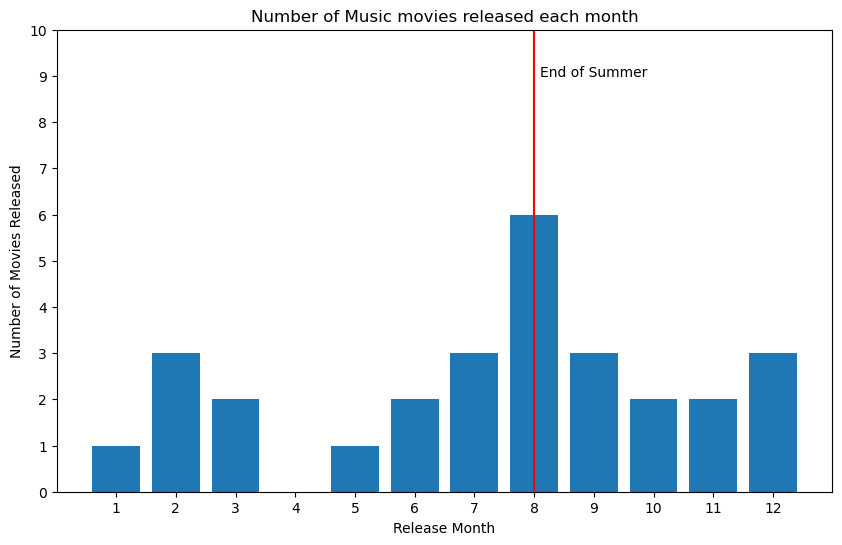

In [51]:
fig,ax = plt.subplots(figsize=(10,6))

ax.bar(x='release_month',height='count', data=music_release_month)
ax.set_xticks(np.arange(1,13))
ax.set_yticks(np.arange(0,11))
ax.set_ylim(0,10)
ax.set_xlabel('Release Month')
ax.set_ylabel('Number of Movies Released')
ax.set_title('Number of Music movies released each month')
ax.vlines(x=8,ymin=0,ymax=40,color='r')
ax.text(x=8.1,y=9,s='End of Summer');

### For some reason Music movies are more popular in August so we recommend this month for release.

## Medium risk - Runtime

In [52]:
df_music = pd.merge(df_music_movies,imdb,how='inner',on='movie')
df_music.drop_duplicates(subset=['movie'],inplace=True)

runtime_music_mean = df_music['runtime_minutes'].mean()
runtime_music_std = df_music['runtime_minutes'].std()
n_music = len(df_music['runtime_minutes'])
err_music = runtime_music_std/n_music**0.5

Tcrit = stats.t.ppf(0.975,n_music-1)

runtime_music_upper = runtime_music_mean + Tcrit*err_music
runtime_music_lower = runtime_music_mean - Tcrit*err_music

print(f'The duration of the Music movie should be in between {floor(runtime_music_lower)} and {ceil(runtime_music_upper)} minutes.')

The duration of the Music movie should be in between 96 and 113 minutes.


# High risk

We now do the same with the higher roisk budget.

In [53]:
tn_high_risk

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI
1242,2013-11-01,Mr. Nobody,46500000,3622,22254,2013,-46477746,-0.999521
1536,2007-03-16,Nomad,40000000,79123,79123,2007,-39920877,-0.998022
1535,2004-09-24,The Last Shot,40000000,463730,463730,2004,-39536270,-0.988407
1582,2001-11-30,Texas Rangers,38000000,623374,623374,2001,-37376626,-0.983595
1531,2008-12-12,Delgo,40000000,915840,915840,2008,-39084160,-0.977104
...,...,...,...,...,...,...,...,...
629,2017-06-30,Despicable Me 3,75000000,264624300,1034727750,2017,959727750,12.796370
955,2016-02-12,Deadpool,58000000,363070709,801025593,2016,743025593,12.810786
1377,2015-02-13,Fifty Shades of Grey,40000000,166167230,570998101,2015,530998101,13.274953
672,2015-07-10,Minions,74000000,336045770,1160336173,2015,1086336173,14.680219


In [54]:
df_highrisk_merged1 = pd.merge(tn_high_risk,movie_db,how='inner',on='movie')
df_highrisk_merged1.drop_duplicates(subset=['release_date','genres','movie'], inplace=True)
df_highrisk_merged1.drop('original_title', axis=1, inplace=True)
df_highrisk_merged1

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,genres
0,2013-11-01,Mr. Nobody,46500000,3622,22254,2013,-46477746,-0.999521,Science Fiction
1,2013-11-01,Mr. Nobody,46500000,3622,22254,2013,-46477746,-0.999521,Drama
2,2013-11-01,Mr. Nobody,46500000,3622,22254,2013,-46477746,-0.999521,Romance
3,2013-11-01,Mr. Nobody,46500000,3622,22254,2013,-46477746,-0.999521,Fantasy
4,2011-05-06,There Be Dragons,36000000,1069334,4020990,2011,-31979010,-0.888306,Drama
...,...,...,...,...,...,...,...,...,...
2001,2015-07-10,Minions,74000000,336045770,1160336173,2015,1086336173,14.680219,Animation
2002,2015-07-10,Minions,74000000,336045770,1160336173,2015,1086336173,14.680219,Adventure
2003,2015-07-10,Minions,74000000,336045770,1160336173,2015,1086336173,14.680219,Comedy
2004,2018-11-02,Bohemian Rhapsody,55000000,216303339,894985342,2018,839985342,15.272461,Drama


In [55]:
df_highrisk_merged2 = pd.merge(left=tn_high_risk, right=movie_db,how='inner',left_on='movie', right_on='original_title')
df_highrisk_merged2.drop_duplicates(subset=['release_date','genres','movie_x'], inplace=True)
df_highrisk_merged2.rename(columns={'movie_x':'movie'},inplace=True)
df_highrisk_merged2.drop(['original_title', 'movie_y'],axis=1,inplace=True)
df_highrisk_merged2

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,genres
0,2013-11-01,Mr. Nobody,46500000,3622,22254,2013,-46477746,-0.999521,Science Fiction
1,2013-11-01,Mr. Nobody,46500000,3622,22254,2013,-46477746,-0.999521,Drama
2,2013-11-01,Mr. Nobody,46500000,3622,22254,2013,-46477746,-0.999521,Romance
3,2013-11-01,Mr. Nobody,46500000,3622,22254,2013,-46477746,-0.999521,Fantasy
4,2011-05-06,There Be Dragons,36000000,1069334,4020990,2011,-31979010,-0.888306,Drama
...,...,...,...,...,...,...,...,...,...
1972,2015-07-10,Minions,74000000,336045770,1160336173,2015,1086336173,14.680219,Animation
1973,2015-07-10,Minions,74000000,336045770,1160336173,2015,1086336173,14.680219,Adventure
1974,2015-07-10,Minions,74000000,336045770,1160336173,2015,1086336173,14.680219,Comedy
1975,2018-11-02,Bohemian Rhapsody,55000000,216303339,894985342,2018,839985342,15.272461,Drama


In [56]:
df_highrisk_merged3 = pd.merge(tn_high_risk,imdb,how='inner',on='movie')
df_highrisk_merged3.drop_duplicates(subset=['release_date','movie'], inplace=True)
df_highrisk_merged3.drop(['runtime_minutes', 'start_year','director'], axis=1, inplace=True)
df_highrisk_merged3

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,genres
0,2007-03-16,Nomad,40000000,79123,79123,2007,-39920877,-0.998022,Drama
3,2004-09-24,The Last Shot,40000000,463730,463730,2004,-39536270,-0.988407,Action
5,2019-06-14,Men in Black: International,110000000,3100000,3100000,2019,-106900000,-0.971818,"Action,Adventure,Comedy"
6,2011-05-06,There Be Dragons,36000000,1069334,4020990,2011,-31979010,-0.888306,"Biography,Drama,War"
7,2017-04-21,The Promise,90000000,8224288,10551417,2017,-79448583,-0.882762,Comedy
...,...,...,...,...,...,...,...,...,...
819,2017-06-30,Despicable Me 3,75000000,264624300,1034727750,2017,959727750,12.796370,"Adventure,Animation,Comedy"
820,2016-02-12,Deadpool,58000000,363070709,801025593,2016,743025593,12.810786,"Action,Adventure,Comedy"
821,2015-02-13,Fifty Shades of Grey,40000000,166167230,570998101,2015,530998101,13.274953,"Drama,Romance,Thriller"
822,2015-07-10,Minions,74000000,336045770,1160336173,2015,1086336173,14.680219,"Adventure,Animation,Comedy"


In [57]:
df_highrisk_merged3['genres'] = df_highrisk_merged3['genres'].str.split(',')
df_highrisk_merged3 = df_highrisk_merged3.explode('genres')
# df_highrisk_merged3['genres'].value_counts()

In [58]:
df_highrisk_exploded = pd.concat([df_highrisk_merged1, df_highrisk_merged2, df_highrisk_merged3])
df_highrisk_exploded.drop_duplicates(subset=['release_date','movie','genres'], inplace=True)
df_highrisk_exploded['genres'].value_counts()

genres
Action             328
Adventure          303
Drama              243
Comedy             229
Thriller           164
Fantasy            149
Family             141
Science Fiction    127
Animation          103
Crime              100
Sci-Fi              86
Romance             61
Mystery             56
Horror              47
Biography           35
History             26
Documentary         23
War                 22
Music               15
Western             10
Sport                9
Musical              5
TV Movie             4
Name: count, dtype: int64

In [59]:
df_highrisk_exploded['genres'].replace(to_replace='Science Fiction', value='Sci-Fi',inplace=True)
df_highrisk_exploded['genres'].value_counts()

/tmp/ipykernel_102626/1961549059.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_highrisk_exploded['genres'].replace(to_replace='Science Fiction', value='Sci-Fi',inplace=True)


genres
Action         328
Adventure      303
Drama          243
Comedy         229
Sci-Fi         213
Thriller       164
Fantasy        149
Family         141
Animation      103
Crime          100
Romance         61
Mystery         56
Horror          47
Biography       35
History         26
Documentary     23
War             22
Music           15
Western         10
Sport            9
Musical          5
TV Movie         4
Name: count, dtype: int64

## High risk - Genre

In [60]:
df_highrisk_exploded.groupby('genres')['ROI'].median().sort_values(ascending=False).reset_index().head()

,genres,ROI
0,Animation,1.969215
1,Sci-Fi,1.778310
2,Adventure,1.714085
3,Family,1.671141
4,Biography,1.649823


In [61]:
df_highrisk_exploded.groupby('genres')['worldwide_net'].median().sort_values(ascending=False).reset_index().head()

,genres,worldwide_net
0,Animation,228648063.0
1,Sci-Fi,220098020.0
2,Adventure,179115534.0
3,Family,166562312.0
4,Fantasy,155270083.0


In [62]:
#Let us calculate the probability that an Animation, Sci-Fi and Adventure movie will make profits
#Animation first
mean_animation = df_highrisk_exploded[df_highrisk_exploded['genres']=='Animation']['worldwide_net'].mean()/10**6
std_animation = df_highrisk_exploded[df_highrisk_exploded['genres']=='Animation']['worldwide_net'].std()/10**6
n_animation = len(df_highrisk_exploded[df_highrisk_exploded['genres']=='Animation']['worldwide_net'])

t_animation_100 = (100-mean_animation)/(std_animation/n_animation**0.5)
t_animation_200 = (200-mean_animation)/(std_animation/n_animation**0.5)
t_animation_300 = (300-mean_animation)/(std_animation/n_animation**0.5)
t_animation_350 = (350-mean_animation)/(std_animation/n_animation**0.5)
print(f'T scores for profit of: \n$100 million = {t_animation_100}\n$200 million = {t_animation_200}\n$300 million = {t_animation_300}\n$350 million = {t_animation_350}\n')

prob_animation_100 = 1-stats.t.cdf(t_animation_100,df=n_animation-1)
prob_animation_200 = 1-stats.t.cdf(t_animation_200,df=n_animation-1)
prob_animation_300 = 1-stats.t.cdf(t_animation_300,df=n_animation-1)
prob_animation_350 = 1-stats.t.cdf(t_animation_350,df=n_animation-1)
print(f'Probability for profit f: \n$100 million = {prob_animation_100}\n$200 million = {prob_animation_200}\n$300 million = {prob_animation_300}\n$350 million = {prob_animation_350}\n')

animation_avg_cost = df_highrisk_exploded[df_highrisk_exploded['genres'] == 'Animation']['production_budget'].mean()
print(f'Average cost of animation movies above $20 million are ${animation_avg_cost/10**6:.02f} millions')

T scores for profit of: 
$100 million = -6.942394636239825
$200 million = -3.5913826663853423
$300 million = -0.24037069653085955
$350 million = 1.4351352883963817

Probability for profit f: 
$100 million = 0.9999999998168365
$200 million = 0.9997460681006808
$300 million = 0.5947373310370614
$350 million = 0.07715392088809236

Average cost of animation movies above $20 million are $109.87 millions


In [63]:
#Let us calculate the probability that a scifi movie will make profits
mean_scifi = df_highrisk_exploded[df_highrisk_exploded['genres']=='Sci-Fi']['worldwide_net'].mean()/10**6
std_scifi = df_highrisk_exploded[df_highrisk_exploded['genres']=='Sci-Fi']['worldwide_net'].std()/10**6
n_scifi = len(df_highrisk_exploded[df_highrisk_exploded['genres']=='Sci-Fi']['worldwide_net'])

t_scifi_100 = (100-mean_scifi)/(std_scifi/n_scifi**0.5)
t_scifi_200 = (200-mean_scifi)/(std_scifi/n_scifi**0.5)
t_scifi_300 = (300-mean_scifi)/(std_scifi/n_scifi**0.5)
t_scifi_350 = (350-mean_scifi)/(std_scifi/n_scifi**0.5)
print(f'T scores for profit of: \n$100 million = {t_scifi_100}\n$200 million = {t_scifi_200}\n$300 million = {t_scifi_300}\n$350 million = {t_scifi_350}\n')

prob_scifi_100 = 1-stats.t.cdf(t_scifi_100,df=n_scifi-1)
prob_scifi_200 = 1-stats.t.cdf(t_scifi_200,df=n_scifi-1)
prob_scifi_300 = 1-stats.t.cdf(t_scifi_300,df=n_scifi-1)
prob_scifi_350 = 1-stats.t.cdf(t_scifi_350,df=n_scifi-1)
print(f'Probability for profit f: \n$100 million = {prob_scifi_100}\n$200 million = {prob_scifi_200}\n$300 million = {prob_scifi_300}\n$350 million = {prob_scifi_350}\n')

scifi_avg_cost = df_highrisk_exploded[df_highrisk_exploded['genres'] == 'Sci-Fi']['production_budget'].mean()
print(f'Average cost of Sci-Fi movies above $20 million are ${scifi_avg_cost/10**6:.02f} millions')

T scores for profit of: 
$100 million = -9.263001427062187
$200 million = -5.252235667837255
$300 million = -1.2414699086123224
$350 million = 0.7639129710001439

Probability for profit f: 
$100 million = 1.0
$200 million = 0.9999998176509557
$300 million = 0.8920979817943603
$350 million = 0.22288422982561462

Average cost of Sci-Fi movies above $20 million are $133.26 millions


In [64]:
#Let us calculate the probability that a adventure movie will make profits
mean_adventure = df_highrisk_exploded[df_highrisk_exploded['genres']=='Adventure']['worldwide_net'].mean()/10**6
std_adventure = df_highrisk_exploded[df_highrisk_exploded['genres']=='Adventure']['worldwide_net'].std()/10**6
n_adventure = len(df_highrisk_exploded[df_highrisk_exploded['genres']=='Adventure']['worldwide_net'])

t_adventure_100 = (100-mean_adventure)/(std_adventure/n_adventure**0.5)
t_adventure_200 = (200-mean_adventure)/(std_adventure/n_adventure**0.5)
t_adventure_300 = (300-mean_adventure)/(std_adventure/n_adventure**0.5)
t_adventure_350 = (350-mean_adventure)/(std_adventure/n_adventure**0.5)
print(f'T scores for profit of: \n$100 million = {t_adventure_100}\n$200 million = {t_adventure_200}\n$300 million = {t_adventure_300}\n$350 million = {t_adventure_350}\n')

prob_adventure_100 = 1-stats.t.cdf(t_adventure_100,df=n_adventure-1)
prob_adventure_200 = 1-stats.t.cdf(t_adventure_200,df=n_adventure-1)
prob_adventure_300 = 1-stats.t.cdf(t_adventure_300,df=n_adventure-1)
prob_adventure_350 = 1-stats.t.cdf(t_adventure_350,df=n_adventure-1)
print(f'Probability for profit f: \n$100 million = {prob_adventure_100}\n$200 million = {prob_adventure_200}\n$300 million = {prob_adventure_300}\n$350 million = {prob_adventure_350}\n')

adventure_avg_cost = df_highrisk_exploded[df_highrisk_exploded['genres'] == 'Adventure']['production_budget'].mean()
print(f'Average cost of Adventure movies above $20 million are ${adventure_avg_cost/10**6:.02f} millions')

T scores for profit of: 
$100 million = -10.136314209284892
$200 million = -4.824164279336895
$300 million = 0.4879856506111035
$350 million = 3.1440606155851025

Probability for profit f: 
$100 million = 1.0
$200 million = 0.999998883029583
$300 million = 0.31295704864162976
$350 million = 0.0009159736985646649

Average cost of Adventure movies above $20 million are $127.28 millions


## High Risk - Directors

FInally, for high risk budget.

In [65]:
df_scifi_movies = df_highrisk_exploded[df_highrisk_exploded['genres']=='Sci-Fi']
df_scifi_directors = pd.merge(df_scifi_movies,imdb,how='inner',on='movie')
df_scifi_directors

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,genres_x,start_year,runtime_minutes,genres_y,director
0,2017-01-13,Monster Trucks,125000000,33370166,61642798,2017,-63357202,-0.506858,Sci-Fi,2016,104.0,"Action,Adventure,Comedy",Chris Wedge
1,2011-04-08,Your Highness,50000000,21596445,26121638,2011,-23878362,-0.477567,Sci-Fi,2011,102.0,"Adventure,Comedy,Fantasy",David Gordon Green
2,2013-03-15,Upside Down,50000000,102118,26387039,2013,-23612961,-0.472259,Sci-Fi,2012,109.0,"Drama,Fantasy,Romance",Juan Solanas
3,2013-03-15,Upside Down,50000000,102118,26387039,2013,-23612961,-0.472259,Sci-Fi,2011,NaN,Drama,John Shepphird
4,2013-03-15,Upside Down,50000000,102118,26387039,2013,-23612961,-0.472259,Sci-Fi,2012,81.0,Drama,Ajay Singh
...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,2017-01-27,Resident Evil: The Final Chapter,40000000,26844692,314101190,2017,274101190,6.852530,Sci-Fi,2016,107.0,"Action,Horror,Sci-Fi",Paul W.S. Anderson
259,2012-03-23,The Hunger Games,80000000,408010692,677923379,2012,597923379,7.474042,Sci-Fi,2012,142.0,"Action,Adventure,Sci-Fi",Gary Ross
260,2014-07-25,Lucy,40000000,126573960,457507776,2014,417507776,10.437694,Sci-Fi,2014,89.0,"Action,Sci-Fi,Thriller",Luc Besson
261,2014-07-25,Lucy,40000000,126573960,457507776,2014,417507776,10.437694,Sci-Fi,2016,9.0,"Animation,Documentary",Elisa Chee


In [66]:
df_scifi_directors.drop_duplicates(subset=['movie','director'],inplace=True)
df_scifi_directors.drop(['release_date','production_budget','domestic_gross','worldwide_gross','release_year','ROI','genres_x','start_year', 'runtime_minutes','genres_y'],axis=1,inplace=True)
df_scifi_directors.sort_values('director')

,movie,worldwide_net,director
22,Vice,10883171,Adam McKay
4,Upside Down,-23612961,Ajay Singh
26,The Watch,12130045,Akiva Schaffer
51,The Book of Eli,78750817,Albert Hughes
11,Annihilation,-11929085,Alex Garland
...,...,...,...
18,Transcendence,3039258,Wally Pfister
139,Maze Runner: The Scorch Trials,249566162,Wes Ball
102,Home,255997896,Yotam Rozin
83,Man of Steel,442999518,Zack Snyder


In [67]:
director_count = df_scifi_directors.groupby('director')['worldwide_net'].count().reset_index().sort_values('worldwide_net',ascending=False)#.iloc[:15]#['director'].iloc[:7]
director_count = director_count.rename(columns={'worldwide_net':'count'})
director_count = (director_count[director_count['count']>2])
director_count

,director,count
116,Paul W.S. Anderson,3
122,Ridley Scott,3
12,Anthony Russo,3
48,Francis Lawrence,3
103,Michael Bay,3


In [68]:
director_list = list(director_count['director'])
director_list

['Paul W.S. Anderson',
 'Ridley Scott',
 'Anthony Russo',
 'Francis Lawrence',
 'Michael Bay']

In [69]:
scifi_topdirectors = df_scifi_directors[df_scifi_directors['director'].isin(director_list)].groupby('director')['worldwide_net'].median().reset_index().sort_values('worldwide_net',ascending=False)
scifi_topdirectors.rename(columns={'worldwide_net': 'Median Profit'})
#list_scifi_topdirectors

,director,Median Profit
2,Michael Bay,894039076.0
0,Anthony Russo,890069413.0
1,Francis Lawrence,641575131.0
4,Ridley Scott,277448265.0
3,Paul W.S. Anderson,238374190.0


In [70]:
df_scifi_directors[df_scifi_directors['director'].isin(scifi_topdirectors['director'])].sort_values('director')#.drop_duplicates(subset=['movie', 'director'])

,movie,worldwide_net,director
126,Captain America: The Winter Soldier,544401889,Anthony Russo
132,Captain America: Civil War,890069413,Anthony Russo
253,Avengers: Infinity War,1748134200,Anthony Russo
123,The Hunger Games: Mockingjay - Part 2,488986787,Francis Lawrence
148,The Hunger Games: Mockingjay - Part 1,641575131,Francis Lawrence
151,The Hunger Games: Catching Fire,734868047,Francis Lawrence
80,Transformers: The Last Knight,385893340,Michael Bay
144,Transformers: Age of Extinction,894039076,Michael Bay
145,Transformers: Dark of the Moon,928790543,Michael Bay
115,Resident Evil: Retribution,175647629,Paul W.S. Anderson


Our recommendation for top directors are (in order of profit):
- For movies about robots, Michael Bay;
- For movies based on comics, Anthony Russo;
- For movies based on books, Francis Lawrence;

## High Risk - Release Month

In [71]:
df_scifi_movies = df_highrisk_exploded[df_highrisk_exploded['genres']=='Sci-Fi']
df_scifi_movies

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,genres
0,2013-11-01,Mr. Nobody,46500000,3622,22254,2013,-46477746,-0.999521,Sci-Fi
83,2017-01-13,Monster Trucks,125000000,33370166,61642798,2017,-63357202,-0.506858,Sci-Fi
97,2011-04-08,Your Highness,50000000,21596445,26121638,2011,-23878362,-0.477567,Sci-Fi
104,2013-03-15,Upside Down,50000000,102118,26387039,2013,-23612961,-0.472259,Sci-Fi
135,2011-10-14,The Thing,38000000,16999934,27573078,2011,-10426922,-0.274393,Sci-Fi
...,...,...,...,...,...,...,...,...,...
792,2015-06-12,Jurassic World,215000000,652270625,1648854864,2015,1433854864,6.669092,Sci-Fi
793,2018-06-22,Jurassic World: Fallen Kingdom,170000000,417719760,1305772799,2018,1135772799,6.681016,Sci-Fi
794,2017-01-27,Resident Evil: The Final Chapter,40000000,26844692,314101190,2017,274101190,6.852530,Sci-Fi
803,2012-03-23,The Hunger Games,80000000,408010692,677923379,2012,597923379,7.474042,Sci-Fi


In [72]:
df_scifi_movies['release_month'] = pd.to_datetime(df_scifi_movies['release_date'], format='%m').dt.month
df_scifi_movies.head()

/tmp/ipykernel_102626/2176942267.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scifi_movies['release_month'] = pd.to_datetime(df_scifi_movies['release_date'], format='%m').dt.month


,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,genres,release_month
0,2013-11-01,Mr. Nobody,46500000,3622,22254,2013,-46477746,-0.999521,Sci-Fi,11
83,2017-01-13,Monster Trucks,125000000,33370166,61642798,2017,-63357202,-0.506858,Sci-Fi,1
97,2011-04-08,Your Highness,50000000,21596445,26121638,2011,-23878362,-0.477567,Sci-Fi,4
104,2013-03-15,Upside Down,50000000,102118,26387039,2013,-23612961,-0.472259,Sci-Fi,3
135,2011-10-14,The Thing,38000000,16999934,27573078,2011,-10426922,-0.274393,Sci-Fi,10


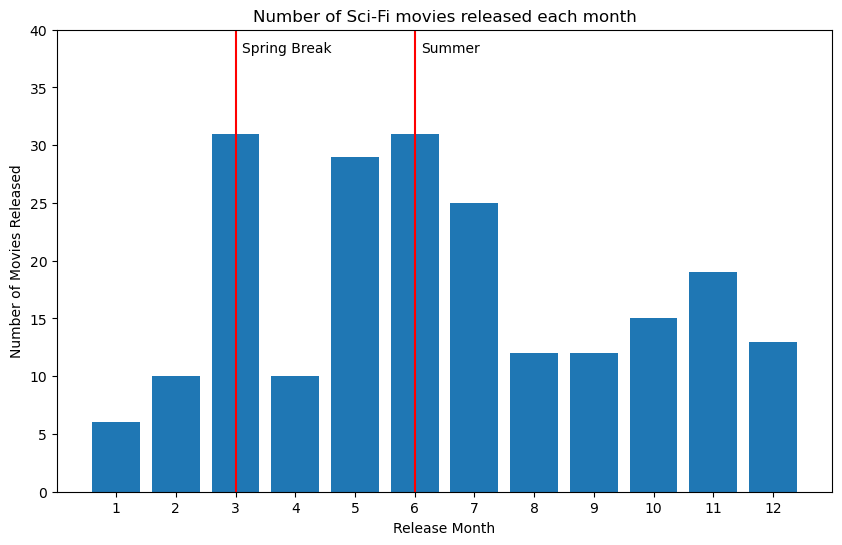

In [73]:
month_count = df_scifi_movies.groupby('release_month').count()['genres'].reset_index().rename(columns={'genres':'count'})

fig,ax = plt.subplots(figsize=(10,6))

ax.bar(x='release_month',height='count', data=month_count)
ax.set_xticks(np.arange(1,13))
ax.set_yticks(np.arange(0,45,5))
ax.set_ylim(0,40)
ax.set_xlabel('Release Month')
ax.set_ylabel('Number of Movies Released')
ax.set_title('Number of Sci-Fi movies released each month')
ax.vlines(x=3,ymin=0,ymax=40,color='r')
ax.vlines(x=6,ymin=0,ymax=40,color='r')
ax.text(x=3.1,y=38,s='Spring Break')
ax.text(x=6.1,y=38,s='Summer');

Movie should be released either in March for Spring Break or in June for Summer.

## High Risk - Runtime

In [74]:
df_scifi = pd.merge(df_scifi_movies,imdb,how='inner',on='movie')
df_scifi.drop_duplicates(subset=['movie'],inplace=True)

runtime_scifi_mean = df_scifi['runtime_minutes'].mean()
runtime_scifi_std = df_scifi['runtime_minutes'].std()
n_scifi = len(df_scifi['runtime_minutes'])
err_scifi = runtime_scifi_std/n_scifi**0.5

Tcrit = stats.t.ppf(0.975,n_scifi-1)

runtime_scifi_upper = runtime_scifi_mean + Tcrit*err_scifi
runtime_scifi_lower = runtime_scifi_mean - Tcrit*err_scifi

print(f'The duration of the Sci-Fi movie should be in between {floor(runtime_scifi_lower)} and {ceil(runtime_scifi_upper)} minutes.')

The duration of the Sci-Fi movie should be in between 115 and 123 minutes.


## Recommendations

**Low Risk:**
* Genre: Horror
* Director: Jordan Peele or John R. Leonetti
* Best release date: Halloween (October) or Easter (April)
* Runtime: 96 to 100 minutes
* Average cost: $7.53 millions

**Medium Risk:**
* Genre: Music
* Director: Damien Chazelle (La La Land)
* Best release date: August
* Runtime: 96 to 113 minutes
* Average cost: $21.93 millions

**High Risk:**
* Genre: Sci-Fi
* Director: Michael Bay (Transformers), Anthony Russo (Marvel), Francis Lawrence (Hunger Games)
* Best release date: March (Spring Break) or June (Summer)
* Runtime: 112 to 120 minutes
* Average cost: $155.73 millions


## Next Steps

For further steps we recommend expanding analysis into several directions:

* Explore data on profits and movie perfomance on streaming services.

* Add budgets spent on marketing. ["Many people get confused when they hear that a movie with a production budget of 100 million grosses 150 million worldwide and loses money. But the brutal fact is that movies get sunk by the massive costs of marketing and distribution all the time."](https://www.studiobinder.com/blog/production-budget/)


## Contact
For contact with the authors of the project, please feel free to add us on LinkedIn and message us or check out our other projects.

[LinkedIn: Cayke Felipe dos Anjos](https://www.linkedin.com/in/cayke-fda/)

[GitHub: Cayke Felipe dos Anjos](https://github.com/cayke-fda)


[LinkedIn: Dolgor Purbueva](https://www.linkedin.com/in/purbuyeva/)

[GitHub: Dolgor Purbueva](https://github.com/dolgorp)